In [1]:
import os
import json
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from write_csv import read_pkl
from ai_cloud_etl import data_extract_e

In [2]:
# Global Variables
JOB_LOGS = 'e_20190609_15.pkl'

In [3]:
# Plots the correlation matrix for a given dataset
def corr_heatmap(df):
    corr_mat = df.corr()

    fig, ax = plt.subplots(figsize=(15, 8))
    color_map = sns.diverging_palette(220, 10, as_cmap=True)
    
    sns.heatmap(corr_mat, cmap=color_map, annot=True, fmt='0.4f')
    
    plt.xticks(range(len(corr_mat.columns)), corr_mat.columns)
    plt.yticks(range(len(corr_mat.columns)), corr_mat.columns)
    plt.show()

In [4]:
# Data Extraction
df = pd.DataFrame()
df = df.append(read_pkl(JOB_LOGS)[0], sort=True)

In [5]:
# Frequency of jobs per queue
df_freq = pd.DataFrame()
df_freq['queue'] = df['queue']
df_freq['count'] = df_freq.groupby('queue')['queue'].transform('count')
df_freq = df_freq.drop_duplicates()
df_freq

,queue,count
0,short,191286
8,parallel20,516396
14,parallel8,421956
1420,parallel12,14198
4477,volta_gpu,1619
6574,serial,8483
7036,parallel24,2834
7975,volta_login,508
8007,dmlogina8,314
8159,Q3100,1105


In [6]:
# Extract data from a single queue
df = df[df['queue'] == 'short']

In [7]:
# Extract range of dates to work with
df_wt = df[['qtime']]
df_wt['qtime'] = df_wt['qtime'].dt.date
df_wt = df_wt.drop_duplicates()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Get number of running jobs per day

# Function to extract number of running jobs for the day
# Returns a single value containing the number of running jobs that day
def get_num_jobs(date):
    return len(df[(df['start'].dt.date <= date) & (df['etime'].dt.date >= date)])

df_wt['num_jobs'] = df_wt['qtime'].apply(lambda x: get_num_jobs(x))

In [9]:
# Get average wait time per day

# Function that gets the average wait time for a specific date
# Takes the wait times of jobs that were queued on specified date
def get_avg_wt(date):
    return df[df['qtime'].dt.date == date]['wait_time'].mean()

df_wt['wait_time'] = df_wt['qtime'].apply(lambda x: get_avg_wt(x))

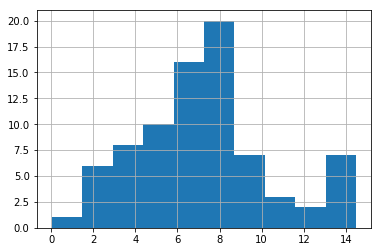

In [11]:
df_wt['num_jobs'].apply(lambda x: np.log2(x + 0.02)).hist() # Apply log scaling to even out the distribution

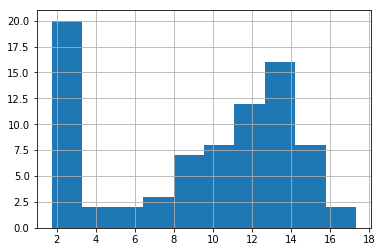

In [12]:
df_wt['wait_time'].apply(lambda x: np.log2(x + 0.02)).hist() # Apply log scaling to even out the distribution

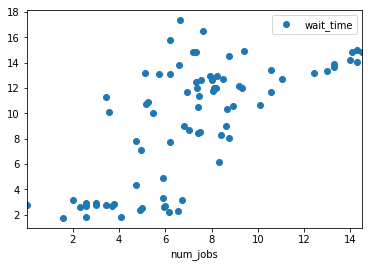

In [13]:
df_wt['num_jobs'] = df_wt['num_jobs'].apply(lambda x: np.log2(x + 0.02))
df_wt['wait_time'] = df_wt['wait_time'].apply(lambda x: np.log2(x + 0.02))
df_wt.plot(x='num_jobs', y='wait_time', style='o')

In [14]:
df_wt.head(5)

,qtime,num_jobs,wait_time
0,2019-05-17,14.285765,14.989777
192,2019-05-16,13.290742,13.908496
53936,2019-05-18,5.883132,3.334539
55521,2019-04-24,5.883132,4.888169
55748,2019-04-25,6.170326,2.237088


In [67]:
# Plot average runtime of running jobs per day

# Function that extracts average walltime of jobs for specified date
def get_avg_wt(date):
    return df[(df['start'].dt.date <= date) & (df['etime'].dt.date >= date)]['resources_used.walltime'].mean()

# Function that extracts average CPU time of jobs for specified date
def get_avg_cput(date):
    return df[(df['start'].dt.date <= date) & (df['etime'].dt.date >= date)]['resources_used.cput'].mean()

In [68]:
df_wt['avg_walltime'] = df_wt['qtime'].apply(lambda x: get_avg_wt(x))
df_wt['avg_cput'] = df_wt['qtime'].apply(lambda x: get_avg_cput(x))

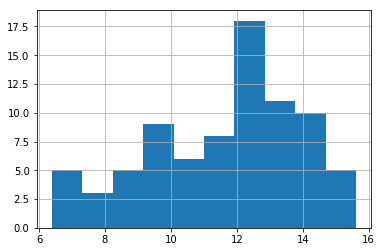

In [69]:
df_wt['avg_walltime'] = df_wt['avg_walltime'].apply(lambda x: np.log2(x))
df_wt['avg_walltime'].hist()

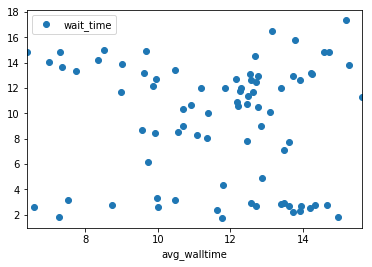

In [70]:
df_wt.plot(x='avg_walltime', y='wait_time', style='o')

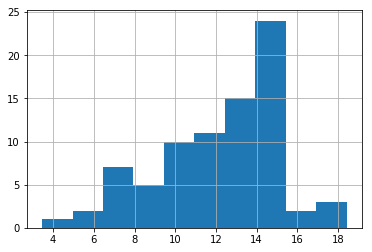

In [71]:
df_wt['avg_cput'] = df_wt['avg_cput'].apply(lambda x: np.log2(x))
df_wt['avg_cput'].hist()

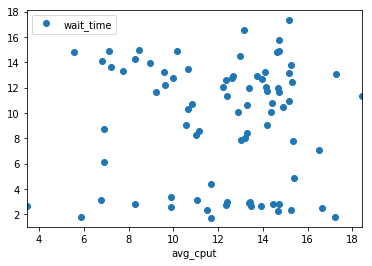

In [72]:
df_wt.plot(x='avg_cput', y='wait_time', style='o')

In [27]:
# Plot average number of cores of running jobs per day

# Function that extracts average number of cores of running jobs per day
def get_avg_cores(date):
    return df[(df['start'].dt.date <= date) & (df['etime'].dt.date >= date)]['resources_used.ncpus'].mean()

df_wt['avg_cores'] = df_wt['qtime'].apply(lambda x: get_avg_cores(x))

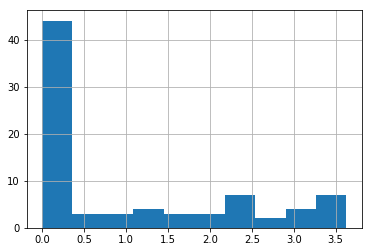

In [38]:
df_wt['avg_cores'].apply(lambda x: np.log2(x)).hist()

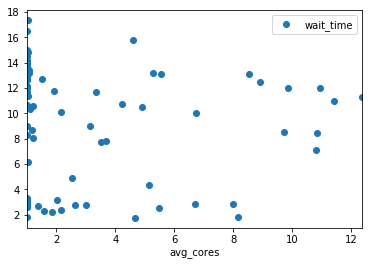

In [39]:
df_wt.plot(x='avg_cores', y='wait_time', style='o')

In [60]:
# Develop new metric - average number of cores * average runtime of running jobs * number of jobs

# Compound number of jobs and average cores used
num_jobs = df_wt['qtime'].apply(lambda x: get_num_jobs(x))
avg_cores = df_wt['qtime'].apply(lambda x: get_avg_cores(x))
df_wt['num_jobs_x_avg_cores'] = num_jobs * avg_cores

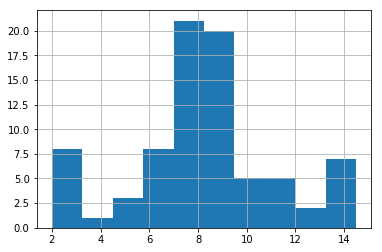

In [63]:
df_wt['num_jobs_x_avg_cores'].apply(lambda x: np.log2(x) if x > 0 else 0).hist()

In [64]:
df_wt['num_jobs_x_avg_cores'] = df_wt['num_jobs_x_avg_cores'].apply(lambda x: np.log2(x) if x > 0 else 0)

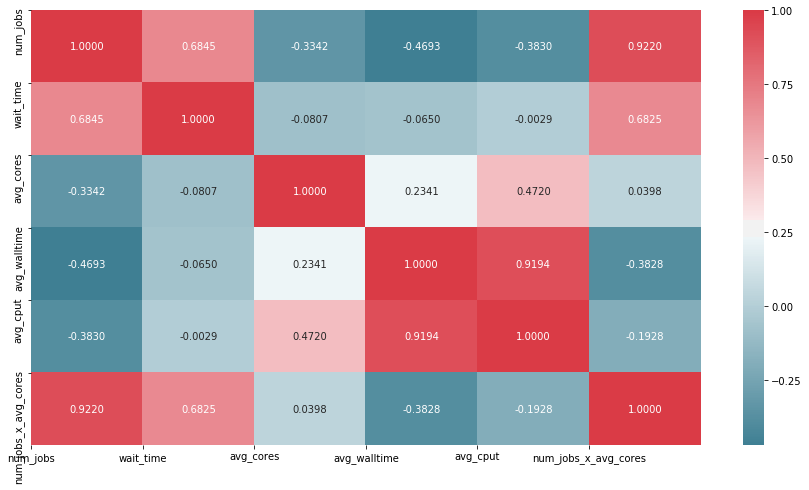

In [73]:
corr_heatmap(df_wt)

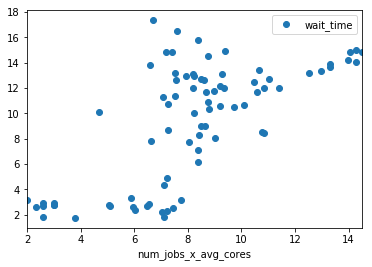

In [66]:
df_wt.plot(x='num_jobs_x_avg_cores', y='wait_time', style='o')

In [84]:
TEST_FILE = 'e_11072019_07.pkl'

from ai_cloud_etl import data_extract_e, data_filter, feature_eng, feature_transform, extract_queues, fit_labels, save_data, load_data
from ai_cloud_model import load_model, load_models, l2_predict

# Data Extraction
df = data_extract_e(TEST_FILE)

# Data Transformation and Engineering
df = feature_eng(df)
df = extract_queues(df)
dept_encoder, queue_encoder, user_encoder = fit_labels(df)
df = feature_transform(df, dept_encoder=dept_encoder, queue_encoder=queue_encoder, user_encoder=user_encoder)
x, y = data_filter(df)

models = load_models()
l2_model = load_model(model_name='xgb_l2')

y_pred = l2_predict(models=models, l2_model=l2_model, x=x, multi=True)
print(y_pred)

ImportError: cannot import name 'FILE_LR_L2' from 'recommendation_global' (/Users/lookaz/Documents/NUS IT/job_logs/model_development/recommendation_global.py)